but once you said you didn't check the clean_route_names file...that's when i looked, and i saw vctc in the list of time_series_utils. if you had checked it, and truly there were multiple route_ids same route_short/long_name, then i would say, yes, aggregate. but once i saw that they had different route_short/long_name, the solution is actually a lot simpler! just remove vctc from the list!
 
so actually, your 2 items to make sure you got it correctly:
remove organization_name from the crosswalk function in merge_data. 
remove vctc + any operator in that list where the time_series_utils pipe should not be used. if you look at the markdown table in the github issue (it's not a 1:m issue, it's a VCTC routes are getting labeled incorrectly), the general rule is short+long name, but the exception is long name only. so vctc should revert back to the rule. remove other operators where doing long name only is giving undesired names (based on the notebook's output i gave you
can you show me the branch after you do these 2 things? these should clear up the majority of issues. 
 
this has happened a couple times now, so when you have a question around a column, follow these steps to debug:
column is (recent_combined_name)
find which dataset brings that in (clean route names)
check what is happening before merging it in, after merging it in (this is a 1:1 merge, so nothing would show up except extra columns appeared)
look at the dataset itself (all the columns for route_id / short name / long name / combined name are here, as well as the "visualization" columns, recent_combined_name, recent_route_name). 
ask why the column you are using isn't behaving. there's a function that applies it. look at the function. time_series_utils. turns out it carves out the exceptions to the rule, and uses route_long_name only sometimes, and VCTC (problem operator) is in this list! if you don't apply that function to VCTC, does it look better? YES!
 
i think most times, you'll get your questions answered if you look this way. i always assume you do these things, so if something's not working, then i'll give you additional suggestions. but if you havent' done this (simplier!) then additional suggestions are actually moot
 
so do not(!) do the aggregation to recent_combined_name. nope nope nope. the answer was much simpler.
 

In [1]:
import altair as alt
import calitp_data_analysis.magics
import geopandas as gpd
import google.auth
import pandas as pd
import yaml
from IPython.display import HTML, Image, Markdown, display, display_html
from omegaconf import OmegaConf
from segment_speed_utils import gtfs_schedule_wrangling, time_series_utils
from shared_utils import (
    catalog_utils,
    gtfs_utils_v2,
    portfolio_utils,
    publish_utils,
    rt_dates,
    rt_utils,
)
from update_vars import GTFS_DATA_DICT, RT_SCHED_GCS, SCHED_GCS, SEGMENT_GCS

readable_dict = OmegaConf.load("readable2.yml")
credentials, project = google.auth.default()

import _report_route_dir_visuals
import merge_data

In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
# portfolio_name = "City and County of San Francisco"
portfolio_name = "Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"

In [4]:
date_list = rt_dates.y2025_dates

## `concatenate_crosswalk_organization` in `merge_data`

In [5]:
FILE = GTFS_DATA_DICT.schedule_tables.gtfs_key_crosswalk

crosswalk_cols = [
    "schedule_gtfs_dataset_key",
    "name",
    "schedule_source_record_id",
    "base64_url",
    "organization_source_record_id",
    "organization_name",
    "caltrans_district",
]

In [6]:
df = time_series_utils.concatenate_datasets_across_dates(
    SCHED_GCS, FILE, date_list, data_type="df", columns=crosswalk_cols
)

In [7]:
df.loc[df.name.str.contains("VCTC")][["name","organization_name"]]

,name,organization_name
162,VCTC GMV Schedule,City of Camarillo
163,VCTC GMV Schedule,Gold Coast Transit District
164,VCTC GMV Schedule,City of Moorpark
165,VCTC GMV Schedule,City of Ojai
166,VCTC GMV Schedule,City of Simi Valley
167,VCTC GMV Schedule,City of Thousand Oaks
168,VCTC GMV Schedule,Ventura County Transportation Commission
162,VCTC GMV Schedule,City of Camarillo
163,VCTC GMV Schedule,Gold Coast Transit District
164,VCTC GMV Schedule,City of Moorpark


In [8]:
with open("../_shared_utils/shared_utils/portfolio_organization_name.yml", "r") as f:
    PORTFOLIO_ORGANIZATIONS_DICT = yaml.safe_load(f)

In [9]:
df = df.assign(
    caltrans_district=df.caltrans_district.map(portfolio_utils.CALTRANS_DISTRICT_DICT)
).pipe(
    portfolio_utils.standardize_portfolio_organization_names,
    PORTFOLIO_ORGANIZATIONS_DICT,
)

In [10]:
df.head(2)

,schedule_gtfs_dataset_key,name,schedule_source_record_id,base64_url,organization_source_record_id,organization_name,caltrans_district,service_date,portfolio_organization_name
0,ff1bc5dde661d62c877165421e9ca257,Santa Ynez Mecatran Schedule,recuWhPXfxMatv6rL,aHR0cDovL2FwcC5tZWNhdHJhbi5jb20vdXJiL3dzL2ZlZWQvYzJsMFpUMXplWFowTzJOc2FXVnVkRDF6Wld4bU8yVjRjR2x5WlQwN2RIbHdaVDFuZEdaek8ydGxlVDAwTWpjd056UTBaVFk0TlRBek9UTXlNREl4TURkak56STBNRFJrTXpZeU5UTTRNekkwWXpJMA==,reckp33bhAuZlmO1M,City of Solvang,05 - San Luis Obispo / Santa Barbara,2025-01-15,City of Solvang
1,f4c3ea214214ee0d96f7646b3e9d69dc,SLO Peak Transit Schedule,rec0EeeizKvsEDfRQ,aHR0cDovL2RhdGEucGVha3RyYW5zaXQuY29tL3N0YXRpY2d0ZnMvMS9ndGZzLnppcA==,recMM99msxjmc6PPv,City of San Luis Obispo,05 - San Luis Obispo / Santa Barbara,2025-01-15,San Luis Obispo Regional Transit Authority


In [11]:
df.loc[df.portfolio_organization_name == portfolio_name]

,schedule_gtfs_dataset_key,name,schedule_source_record_id,base64_url,organization_source_record_id,organization_name,caltrans_district,service_date,portfolio_organization_name
162,1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,recrAG7e0oOiR6FiP,aHR0cHM6Ly9nb3ZjYnVzLmNvbS9ndGZz,recD4Vzt0EDC3VY7I,City of Camarillo,07 - Los Angeles / Ventura,2025-01-15,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
163,1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,recrAG7e0oOiR6FiP,aHR0cHM6Ly9nb3ZjYnVzLmNvbS9ndGZz,recS7GnKTcQVX20HE,Gold Coast Transit District,07 - Los Angeles / Ventura,2025-01-15,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
164,1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,recrAG7e0oOiR6FiP,aHR0cHM6Ly9nb3ZjYnVzLmNvbS9ndGZz,recojKzQsBzE1hjVu,City of Moorpark,07 - Los Angeles / Ventura,2025-01-15,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
165,1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,recrAG7e0oOiR6FiP,aHR0cHM6Ly9nb3ZjYnVzLmNvbS9ndGZz,reckQmUdXUzHFmlVf,City of Ojai,07 - Los Angeles / Ventura,2025-01-15,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
166,1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,recrAG7e0oOiR6FiP,aHR0cHM6Ly9nb3ZjYnVzLmNvbS9ndGZz,rec1ErIn9gG1Isk5W,City of Simi Valley,07 - Los Angeles / Ventura,2025-01-15,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
167,1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,recrAG7e0oOiR6FiP,aHR0cHM6Ly9nb3ZjYnVzLmNvbS9ndGZz,recPJULRJk1Yn824N,City of Thousand Oaks,07 - Los Angeles / Ventura,2025-01-15,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
168,1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,recrAG7e0oOiR6FiP,aHR0cHM6Ly9nb3ZjYnVzLmNvbS9ndGZz,rec7EN71rsZxDFxZd,Ventura County Transportation Commission,07 - Los Angeles / Ventura,2025-01-15,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
162,1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,recrAG7e0oOiR6FiP,aHR0cHM6Ly9nb3ZjYnVzLmNvbS9ndGZz,recD4Vzt0EDC3VY7I,City of Camarillo,07 - Los Angeles / Ventura,2025-02-12,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
163,1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,recrAG7e0oOiR6FiP,aHR0cHM6Ly9nb3ZjYnVzLmNvbS9ndGZz,recS7GnKTcQVX20HE,Gold Coast Transit District,07 - Los Angeles / Ventura,2025-02-12,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
164,1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,recrAG7e0oOiR6FiP,aHR0cHM6Ly9nb3ZjYnVzLmNvbS9ndGZz,recojKzQsBzE1hjVu,City of Moorpark,07 - Los Angeles / Ventura,2025-02-12,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"


In [12]:
df_sched = merge_data.concatenate_schedule_by_route_direction(date_list)

df_avg_speeds = merge_data.concatenate_speeds_by_route_direction(date_list)

df_rt_sched = merge_data.concatenate_rt_vs_schedule_by_route_direction(date_list)

In [13]:
df_sched.head(2)

,schedule_gtfs_dataset_key,route_id,direction_id,time_period,avg_scheduled_service_minutes,avg_stop_miles,n_scheduled_trips,frequency,service_date,is_express,is_ferry,is_rail,is_coverage,is_local,is_downtown_local,is_rapid,typology,name,combined_name,recent_combined_name,recent_route_id,route_primary_direction
0,0139b1253130b33adcd4b3a4490530d2,0177a66b-9f33-407d-a72e-776429fb73d4,NaN,all_day,63.50,0.92,2,0.08,2025-01-15,0.00,0.00,0.00,1.00,0.00,0.00,0.00,coverage,TCRTA TripShot Schedule,C70 LOOP__70,C70 LOOP 70,0177a66b-9f33-407d-a72e-776429fb73d4,Eastbound
1,0139b1253130b33adcd4b3a4490530d2,0177a66b-9f33-407d-a72e-776429fb73d4,NaN,all_day,63.50,5.98,2,0.08,2025-02-12,0.00,0.00,0.00,1.00,0.00,0.00,0.00,coverage,TCRTA TripShot Schedule,C70 LOOP__70,C70 LOOP 70,0177a66b-9f33-407d-a72e-776429fb73d4,Eastbound


In [14]:
df_avg_speeds.head(2)

,schedule_gtfs_dataset_key,route_id,direction_id,time_period,speed_mph,service_date
0,0139b1253130b33adcd4b3a4490530d2,0177a66b-9f33-407d-a72e-776429fb73d4,NaN,all_day,33.49,2025-04-16
1,0139b1253130b33adcd4b3a4490530d2,0177a66b-9f33-407d-a72e-776429fb73d4,NaN,peak,33.49,2025-04-16


In [15]:
df_rt_sched.head(2)

,schedule_gtfs_dataset_key,route_id,direction_id,time_period,minutes_atleast1_vp,minutes_atleast2_vp,total_rt_service_minutes,total_scheduled_service_minutes,total_vp,vp_in_shape,is_early,is_ontime,is_late,n_vp_trips,vp_per_minute,pct_in_shape,pct_rt_journey_atleast1_vp,pct_rt_journey_atleast2_vp,pct_sched_journey_atleast1_vp,pct_sched_journey_atleast2_vp,rt_sched_journey_ratio,avg_rt_service_minutes,service_date
0,0139b1253130b33adcd4b3a4490530d2,0177a66b-9f33-407d-a72e-776429fb73d4,NaN,all_day,159,158,156.95,127.00,473,390,0,1,1,2,3.01,0.82,1.00,1.00,1.00,1.00,1.24,78.47,2025-01-15
1,0139b1253130b33adcd4b3a4490530d2,0177a66b-9f33-407d-a72e-776429fb73d4,NaN,all_day,161,159,158.92,127.00,479,378,0,1,1,2,3.01,0.79,1.00,1.00,1.00,1.00,1.25,79.46,2025-02-12


In [16]:
df2 = merge_data.merge_data_sources_by_route_direction(
    df_sched, df_rt_sched, df_avg_speeds, df
)

In [17]:
df.loc[df.name.str.contains("VCTC")][["schedule_gtfs_dataset_key"]]

,schedule_gtfs_dataset_key
162,1770249a5a2e770ca90628434d4934b1
163,1770249a5a2e770ca90628434d4934b1
164,1770249a5a2e770ca90628434d4934b1
165,1770249a5a2e770ca90628434d4934b1
166,1770249a5a2e770ca90628434d4934b1
167,1770249a5a2e770ca90628434d4934b1
168,1770249a5a2e770ca90628434d4934b1
162,1770249a5a2e770ca90628434d4934b1
163,1770249a5a2e770ca90628434d4934b1
164,1770249a5a2e770ca90628434d4934b1


## Clarification on this portion of `merge_data.py`
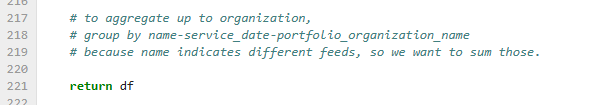

## Check Ventura County Route 80 

In [18]:
df2.columns

Index(['schedule_gtfs_dataset_key', 'route_id', 'direction_id', 'time_period',
       'avg_scheduled_service_minutes', 'avg_stop_miles', 'n_scheduled_trips',
       'frequency', 'service_date', 'is_express', 'is_ferry', 'is_rail',
       'is_coverage', 'is_local', 'is_downtown_local', 'is_rapid', 'typology',
       'name', 'combined_name', 'recent_combined_name', 'recent_route_id',
       'route_primary_direction', 'minutes_atleast1_vp', 'minutes_atleast2_vp',
       'total_rt_service_minutes', 'total_scheduled_service_minutes',
       'total_vp', 'vp_in_shape', 'is_early', 'is_ontime', 'is_late',
       'n_vp_trips', 'vp_per_minute', 'pct_in_shape',
       'pct_rt_journey_atleast1_vp', 'pct_rt_journey_atleast2_vp',
       'pct_sched_journey_atleast1_vp', 'pct_sched_journey_atleast2_vp',
       'rt_sched_journey_ratio', 'avg_rt_service_minutes', 'sched_rt_category',
       'speed_mph', 'schedule_source_record_id', 'base64_url',
       'organization_source_record_id', 'organization_name

In [19]:
df2.service_date.unique()

array(['2025-01-15T00:00:00.000000000', '2025-02-12T00:00:00.000000000',
       '2025-03-12T00:00:00.000000000', '2025-04-16T00:00:00.000000000',
       '2025-05-14T00:00:00.000000000'], dtype='datetime64[ns]')

In [20]:
route_80_89 = df2.loc[
    (df2.portfolio_organization_name == portfolio_name)
    & (df2.recent_combined_name == "80-89 Coastal Express")
    & (df2.service_date == "2025-05-14T00:00:00.000000000")
]

In [21]:
route_80_89.name.value_counts()

VCTC GMV Schedule    1673
Name: name, dtype: int64

### There are two directions, 3 time periods so I should only see 6 rows per date? Also there are many duplicates -> dropped from 239 to 41. 

In [22]:
len(route_80_89), len(route_80_89.drop_duplicates())

(1673, 287)

In [23]:
route_80_89_dedup = route_80_89.drop_duplicates()

In [24]:
route_80_89_dedup.columns

Index(['schedule_gtfs_dataset_key', 'route_id', 'direction_id', 'time_period',
       'avg_scheduled_service_minutes', 'avg_stop_miles', 'n_scheduled_trips',
       'frequency', 'service_date', 'is_express', 'is_ferry', 'is_rail',
       'is_coverage', 'is_local', 'is_downtown_local', 'is_rapid', 'typology',
       'name', 'combined_name', 'recent_combined_name', 'recent_route_id',
       'route_primary_direction', 'minutes_atleast1_vp', 'minutes_atleast2_vp',
       'total_rt_service_minutes', 'total_scheduled_service_minutes',
       'total_vp', 'vp_in_shape', 'is_early', 'is_ontime', 'is_late',
       'n_vp_trips', 'vp_per_minute', 'pct_in_shape',
       'pct_rt_journey_atleast1_vp', 'pct_rt_journey_atleast2_vp',
       'pct_sched_journey_atleast1_vp', 'pct_sched_journey_atleast2_vp',
       'rt_sched_journey_ratio', 'avg_rt_service_minutes', 'sched_rt_category',
       'speed_mph', 'schedule_source_record_id', 'base64_url',
       'organization_source_record_id', 'organization_name

In [25]:
route_80_89_dedup.time_period.value_counts()

all_day    133
offpeak     91
peak        63
Name: time_period, dtype: int64

### What about unique route ID's that are repeated for the same `key, recent_combined_name,service_date, and portfolio_organization_name` combo?

In [26]:
route_80_89_dedup.route_id.unique()

array(['4134', '4136', '4137', '4138', '4141', '4142', '4143', '4144',
       '4145', '4146', '4147', '4148'], dtype=object)

In [27]:
route_80_89_dedup.loc[
    (route_80_89_dedup.time_period == "peak") & (route_80_89_dedup.direction_id == 1)
][
    [
        "portfolio_organization_name",
        "recent_combined_name",
        "route_id",
        "recent_route_id",
        "direction_id",
        "time_period",
        "avg_scheduled_service_minutes",
        "avg_stop_miles",
        "n_scheduled_trips",
        "frequency",
        "route_primary_direction",
        # "minutes_atleast1_vp",
        # "minutes_atleast2_vp",
        # "total_rt_service_minutes",
        # "total_scheduled_service_minutes",
        # "total_vp",
        # "vp_in_shape",
        # "is_early",
        # "is_ontime",
        # "is_late",
        # "n_vp_trips",
        "vp_per_minute",
        "pct_in_shape",
        "pct_rt_journey_atleast1_vp",
        "pct_rt_journey_atleast2_vp",
        "pct_sched_journey_atleast1_vp",
        "pct_sched_journey_atleast2_vp",
        "rt_sched_journey_ratio",
        "avg_rt_service_minutes",
        "speed_mph",
    ]
].T

,54082,54083,54084,54085,54086,54087,54088,54775,54776,54777,54778,54779,54780,54781,55265,55266,55267,55268,55269,55270,55271,56000,56001,56002,56003,56004,56005,56006,56448,56449,56450,56451,56452,56453,56454,56896,56897,56898,56899,56900,56901,56902,57386,57387,57388,57389,57390,57391,57392,57876,57877,57878,57879,57880,57881,57882
portfolio_organization_name,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)","Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"

# Aggregation per my notebook #17
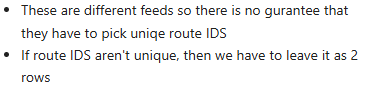
* Need clarification (yes even though I wrote this myself). IF the route IDs are repeated, then we leave them as two rows. What does unpacking any route IDs that are repeated across different `keys` mean?
* Confirm if two different `names` have thes ame `key` that means this is the same feed. 

In [28]:
df2.head(1)

,schedule_gtfs_dataset_key,route_id,direction_id,time_period,avg_scheduled_service_minutes,avg_stop_miles,n_scheduled_trips,frequency,service_date,is_express,is_ferry,is_rail,is_coverage,is_local,is_downtown_local,is_rapid,typology,name,combined_name,recent_combined_name,recent_route_id,route_primary_direction,minutes_atleast1_vp,minutes_atleast2_vp,total_rt_service_minutes,total_scheduled_service_minutes,total_vp,vp_in_shape,is_early,is_ontime,is_late,n_vp_trips,vp_per_minute,pct_in_shape,pct_rt_journey_atleast1_vp,pct_rt_journey_atleast2_vp,pct_sched_journey_atleast1_vp,pct_sched_journey_atleast2_vp,rt_sched_journey_ratio,avg_rt_service_minutes,sched_rt_category,speed_mph,schedule_source_record_id,base64_url,organization_source_record_id,organization_name,caltrans_district,portfolio_organization_name
0,0139b1253130b33adcd4b3a4490530d2,0177a66b-9f33-407d-a72e-776429fb73d4,0,all_day,63.50,0.92,2,0.08,2025-01-15,0.00,0.00,0.00,1.00,0.00,0.00,0.00,coverage,TCRTA TripShot Schedule,C70 LOOP__70,C70 LOOP 70,0177a66b-9f33-407d-a72e-776429fb73d4,Eastbound,159,158,156.95,127.00,473,390,0,1,1,2,3.01,0.82,1.00,1.00,1.00,1.00,1.24,78.47,schedule_and_vp,NaN,recGeFW9Cz2cr1jJd,aHR0cHM6Ly90Y3J0YS50cmlwc2hvdC5jb20vdjEvZ3Rmcy56aXA_cmVnaW9uSWQ9Q0E1NThEREMtRDdGMi00QjQ4LTlDQUMtREVFQTExMzRGODIw,rec4YWVqVwJ9XqDbq,Tulare County Regional Transit Agency,06 - Fresno / Bakersfield,Tulare County Regional Transit Agency


## Check if route_name-direction are unique to the portfolio_organization_name

In [29]:
unique_route_names = (
    df2.groupby(["service_date", "recent_combined_name"])
    .agg({"portfolio_organization_name": "nunique"})
    .reset_index()
)

In [30]:
unique_route_names2 = unique_route_names.loc[
    unique_route_names.portfolio_organization_name > 1
]

In [31]:
unique_route_names2.shape

(193, 3)

In [32]:
unique_route_names2.sort_values(
    by=["portfolio_organization_name"], ascending=False
).head()

,service_date,recent_combined_name,portfolio_organization_name
2119,2025-01-15,Route 4,6
11358,2025-05-14,Route 4,6
9044,2025-04-16,Route 4,6
4441,2025-02-12,Route 4,6
6694,2025-03-12,Route 4,6


In [33]:
df2.loc[df2.recent_combined_name == "Route 4"].portfolio_organization_name.unique()

array(['Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)',
       'City of Visalia', 'City of Beaumont',
       'Antelope Valley Transit Authority', 'Redding Area Bus Authority',
       'City of Monterey Park'], dtype=object)

In [34]:
unique_route_ids = (
    df2.groupby([ "portfolio_organization_name", "recent_combined_name"])
    .agg({"route_id": "nunique"})
    .reset_index()
)

In [35]:
unique_route_ids2 = unique_route_ids.loc[unique_route_ids.route_id > 1]

In [36]:
len(unique_route_ids2)

224

In [37]:
unique_route_ids2.sort_values(by=["route_id"], ascending=False)

,portfolio_organization_name,recent_combined_name,route_id
2309,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",80-89 Coastal Express,12
418,City of Elk Grove,Elk Grove Commuter Route,10
419,City of Elk Grove,Elk Grove Local Route,7
721,City of Santa Monica,R10 Downtown LA Freeway Express,3
1532,Peninsula Corridor Joint Powers Board,,3
2310,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",90-99 CSU Channel Islands,3
2307,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",70-74 East County,3
704,City of Santa Monica,18 UCLA - Marina del Rey,3
720,City of Santa Monica,9 Pacific Palisades,3
711,City of Santa Monica,43 26th Street,3


In [38]:
df2.loc[df2.portfolio_organization_name == "City of Elk Grove"][
    ["name", "schedule_gtfs_dataset_key", "portfolio_organization_name"]
].drop_duplicates()

,name,schedule_gtfs_dataset_key,portfolio_organization_name
98030,Elk Grove Schedule,89b0a03002512a909fe8e1a5d00a78a5,City of Elk Grove


In [ ]:
df2.loc[(df2.recent_combined_name == "18 UCLA - Marina del Rey") & (df2.time_period == "peak") & (df2.direction_id == 0)][
    [
        "portfolio_organization_name",
        "recent_combined_name",
        "route_id",
        "direction_id",
        "time_period",
        "avg_scheduled_service_minutes",
        "avg_stop_miles",
        "n_scheduled_trips",
        "frequency",
        "route_primary_direction",
        # "minutes_atleast1_vp",
        # "minutes_atleast2_vp",
        # "total_rt_service_minutes",
        # "total_scheduled_service_minutes",
        # "total_vp",
        # "vp_in_shape",
        # "is_early",
        # "is_ontime",
        # "is_late",
        # "n_vp_trips",
        "vp_per_minute",
        "pct_in_shape",
        "pct_rt_journey_atleast1_vp",
        "pct_rt_journey_atleast2_vp",
        "pct_sched_journey_atleast1_vp",
        "pct_sched_journey_atleast2_vp",
        "rt_sched_journey_ratio",
        "avg_rt_service_minutes",
        "speed_mph",
    ]
].T

## De duplicating on key, name, and portfolio_organization_name

In [ ]:
df3 = df2.drop_duplicates(
    subset=[
        "name",
        "service_date",
        "schedule_gtfs_dataset_key",
        "portfolio_organization_name",
        "recent_combined_name",
        "route_id",
        "time_period",
        "direction_id",
    ]
)

In [ ]:
# Use only 80-89 Coastal Express
df3 = df3.loc[
    (df3.portfolio_organization_name == portfolio_name)
    & (df3.recent_combined_name == "80-89 Coastal Express")
    & (df3.service_date == "2025-05-14T00:00:00.000000000")
    & (df3.time_period == "all_day")
]

In [ ]:
crosswalk_cols = [
    "schedule_gtfs_dataset_key",
    "name",
    "portfolio_organization_name",
]

In [ ]:
df3.columns

## Aggregaate?
* `route_id`, `recent_route_id`,  `combined_name`, and `sched_rt_category` all cause multiple rows to pop up for 80-89 Coastal Express


In [ ]:
groupby_cols = [
    "portfolio_organization_name",
    "direction_id",
    "service_date",
    "recent_combined_name",
    "time_period",
]

### To Calculate again
* 	avg_rt_service_minutes	
* 'avg_scheduled_service_minutes',
 'avg_stop_miles',

In [ ]:
from segment_speed_utils import segment_calcs, metrics

In [ ]:
to_sum = [
    "n_scheduled_trips",
    "minutes_atleast1_vp",
    "minutes_atleast2_vp",
    "total_rt_service_minutes",
    "total_scheduled_service_minutes",
    "total_vp",
    "vp_in_shape",
    "is_early",
    "is_ontime",
    "is_late",
    "n_vp_trips",
]

In [ ]:
agg1 = (
    df3.groupby(
        [
            "schedule_gtfs_dataset_key",
            "direction_id",
            "time_period",
            "service_date",
            "is_express",
            "is_ferry",
            "is_rail",
            "is_coverage",
            "is_local",
            "is_downtown_local",
            "is_rapid",
            "typology",
            "recent_combined_name",
            "route_primary_direction",
            "schedule_source_record_id",
            "base64_url",
            "caltrans_district",
            "portfolio_organization_name",
        ]
    )
    .agg({col: "sum" for col in to_sum})
    .reset_index()
)

In [ ]:
agg1 = (
    agg1.rename(
        columns={
            "total_rt_service_minutes": "rt_service_minutes",
            "total_scheduled_service_minutes": "scheduled_service_minutes",
        }
    )
    .pipe(metrics.calculate_rt_vs_schedule_metrics)
    .rename(
        columns={
            "rt_service_minutes": "total_rt_service_minutes",
            "scheduled_service_minutes": "total_scheduled_service_minutes",
        }
    )
)

In [ ]:
set(list(df3.columns)) - set(list(agg1.columns))

In [ ]:
schd_metric_cols = [
    "avg_scheduled_service_minutes",
    "avg_stop_miles",
    "frequency",
    "total_scheduled_service_minutes",
]

In [ ]:
schd_metrics = segment_calcs.calculate_weighted_averages(
        df=df3[groupby_cols + schd_metric_cols + ["n_scheduled_trips"]],
        group_cols=groupby_cols,
        metric_cols=schd_metric_cols,
        weight_col="n_scheduled_trips",
    )

In [ ]:
metrics.calculate_rt_vs_schedule_metrics??

In [ ]:
df3.loc[df3.direction_id == 1].minutes_atleast1_vp.sum()

In [ ]:
df3.loc[df3.direction_id == 1].total_scheduled_service_minutes.sum()

In [ ]:
df3.loc[df3.direction_id == 1].minutes_atleast2_vp.sum()

In [ ]:
df3.loc[df3.direction_id == 1][
    ["minutes_atleast1_vp", "total_scheduled_service_minutes", "minutes_atleast2_vp"]
]

In [ ]:
route_80_89_dedup.loc[
    (route_80_89_dedup.time_period == "all_day") & (route_80_89_dedup.direction_id == 1)
][["minutes_atleast1_vp", "total_scheduled_service_minutes", "minutes_atleast2_vp"]]

In [ ]:
route_80_89.loc[
    (route_80_89.time_period == "all_day") & (route_80_89.direction_id == 1)
][["minutes_atleast1_vp", "total_scheduled_service_minutes", "minutes_atleast2_vp"]]

In [ ]:
agg1.T